In [27]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
# matplotlib.use("Agg")

# import the necessary packages
import time
import pandas as pd
import seaborn as sn
import keras
import os
import cv2
import pickle
import random
import argparse
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Dense
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import Nadam
from keras.optimizers import RMSprop
from keras.losses import logcosh, binary_crossentropy
from keras.activations import relu, elu, sigmoid
from keras.preprocessing.image import ImageDataGenerator
# import matplotlib
# matplotlib.use("Agg")

In [28]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 3
INIT_LR = 1e-2
BS = 32
IMAGE_DIMS = (224, 224, 3)

In [29]:
from imutils import paths

imagePaths = sorted(list(paths.list_images("fear_classification_minority_duplicated")))
random.seed(42)
random.shuffle(imagePaths)
imagePaths

['fear_classification_minority_duplicated\\non_fear\\non_fear_2185.jpg',
 'fear_classification_minority_duplicated\\non_fear\\non_fear_460.jpg',
 'fear_classification_minority_duplicated\\non_fear\\non_fear_1681.jpg',
 'fear_classification_minority_duplicated\\non_fear\\non_fear_1912.jpg',
 'fear_classification_minority_duplicated\\non_fear\\non_fear_494.jpg',
 'fear_classification_minority_duplicated\\non_fear\\non_fear_1430.jpg',
 'fear_classification_minority_duplicated\\fear\\fear_264 - Copy (7).jpg',
 'fear_classification_minority_duplicated\\fear\\fear_100 - Copy (5).jpg',
 'fear_classification_minority_duplicated\\fear\\fear_53 - Copy (7).jpg',
 'fear_classification_minority_duplicated\\fear\\fear_121 - Copy (7).jpg',
 'fear_classification_minority_duplicated\\non_fear\\non_fear_616.jpg',
 'fear_classification_minority_duplicated\\non_fear\\non_fear_808.jpg',
 'fear_classification_minority_duplicated\\non_fear\\non_fear_1713.jpg',
 'fear_classification_minority_duplicated\\non_f

In [30]:
from keras.preprocessing.image import img_to_array

data = []
labels = []

# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [31]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(
    data.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 6338.64MB


In [32]:
from sklearn.preprocessing import LabelBinarizer

# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [33]:
from sklearn.model_selection import train_test_split

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.2, random_state=42)

In [34]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [36]:
from keras.optimizers import SGD

print("[INFO] compiling model...")
from keras.applications import ResNet50
model = ResNet50()

opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR/EPOCHS)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
print("[INFO] done compiling.")

model.summary()

[INFO] compiling model...
[INFO] done compiling.
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________

In [38]:
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [39]:
# train the network
print("[INFO] training network...")
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)#, class_weight={0:3, 1:1})

# save the model to disk
print("[INFO] serializing network...")
model.save("fear_minority_duplicated_resnet50_300_epochs.model")

[INFO] training network...
Epoch 1/3
134/134 [==============================] - 74s 550ms/step - loss: 0.8342 - accuracy: 0.6465 - val_loss: 0.9107 - val_accuracy: 0.5139
Epoch 2/3
134/134 [==============================] - 57s 422ms/step - loss: 0.4483 - accuracy: 0.7857 - val_loss: 0.8554 - val_accuracy: 0.5139
Epoch 3/3
134/134 [==============================] - 57s 422ms/step - loss: 0.3618 - accuracy: 0.8474 - val_loss: 0.7901 - val_accuracy: 0.5130
[INFO] serializing network...


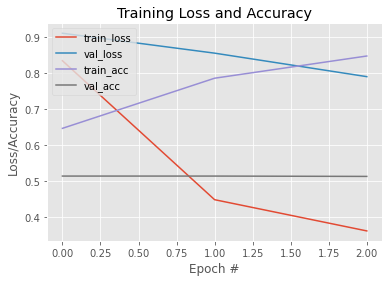

<Figure size 432x288 with 0 Axes>

In [40]:
plt.style.use("ggplot")
%matplotlib inline
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('fear_classification_minority_duplicated_resnet50_300_epochs.png', dpi=100)

In [41]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
 

# predict probabilities for test set
yhat_probs = model.predict(testX, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs, axis=1)

Classification report: 
---------------------------------------------------------- 
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       524
   non-anger       0.51      1.00      0.68       554

    accuracy                           0.51      1078
   macro avg       0.26      0.50      0.34      1078
weighted avg       0.26      0.51      0.35      1078

---------------------------------------------------------- 
Accuracy score: 0.512987
Precision score: 0.513463
Recall score: 0.998195
F1 score: 0.678112
---------------------------------------------------------- 
Confusion matrix: 
[[  0 524]
 [  1 553]]


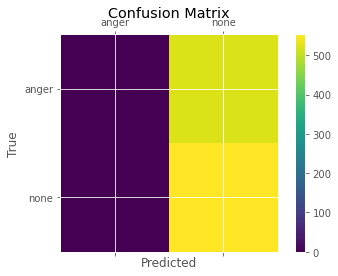

[[  0 524]
 [  1 553]]


In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

classif_report = classification_report(testY, yhat_classes, target_names=['anger', 'non-anger'])
print('Classification report: ')
print('---------------------------------------------------------- ')
print(classif_report)

print('---------------------------------------------------------- ')
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testY, yhat_classes)
print('Accuracy score: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testY, yhat_classes)
print('Precision score: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testY, yhat_classes)
print('Recall score: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testY, yhat_classes)
print('F1 score: %f' % f1)
print('---------------------------------------------------------- ')

# confusion matrix
labels = ['anger', 'none']
matrix = confusion_matrix(testY, yhat_classes)
print('Confusion matrix: ')
print(matrix)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix)
plt.title('Confusion Matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_fear_minority_duplicated_resnet50_300_epochs.png')
plt.show()
print(matrix)